# Statistics, Gaussians,  and Lines

Goals:

 * Demonstrate central limit theorem
 * Describe Gaussian probability
 * Discuss "fitting a line to data" when uncertainties are Gaussian
 * Broadly, understand the simplest way errors are generally treated in science
 
 References:
 
  * http://slittlefair.staff.shef.ac.uk/teaching/phy217/lectures/stats/L18/index.html
  * https://arxiv.org/pdf/1008.4686.pdf
 

Most statistics textbooks and lectures open with a pithy quote.  My favorite, from Ch. 5 of Wall & Jenkins, is 
this "interchange beween Peter Scheuer and his then student, CRJ":

"How do our data look?"

"I've carried out a Kolmogorov-Smirnov test...."

"Ah, that bad."

If the data tell a clear story, you don't need sophisticated statistics to understand and convey the results.

Statistics are our tools to extend our capabilities to learn more from data than they obviously tell, and they are tools to help make sure we don't fool ourselves.  

"Lies, damned lies, and statistics" is a popular quote referencing the idea that we indeed frequently *do* fool ourselves with statistics.

In [1]:
%matplotlib inline
import pylab as pl
import numpy as np
from astropy import units as u, constants, visualization
visualization.quantity_support()
pl.style.use('dark_background')
pl.rcParams['figure.figsize'] = (10,10)
pl.rcParams['font.size'] = 14

## Probability

For a fair coin flip, the probability of getting a heads or tails is equal, and theres no other outcome.

$$P(heads) = P(tails)$$

By definition, the sum of probabilities of all outcomes is 1: 

$$P(heads) + P(tails) = 1$$

therefore

$$P(heads) = P(tails) = 0.5$$


# Summing probabilities

If we want to do this for two coin flips, we want to know $P(heads+heads)$, $P(heads+tails)$, and $P(tails+tails)$.  Since there is only one way to get heads+heads and one way to get tails+tails, those probabilities are equal.  There are two ways to get $P(heads+tails)$: heads then tails or tails then heads.  

So $P(HH) = P(TT) = P(HT)=P(TH)$


$$P(HH) + P(TT) + P(HT) + P(TH) = 1$$
$$P(TH~or~HT) = P(HT) + P(TH) = 2 P(HT) = 0.5$$
$$P(HH) = P(TT) = 0.25$$

# Modeling Random Processes

We can use random number generators (RNGs) to simulate coin flips. 

We use an RNG that produces a number in the range 0 to 1:

In [2]:
np.random.rand()

0.8348910661079323

We say: if the random number is <0.5, call it heads, or if its >0.5, it's tails.

In [3]:
def heads():
    return np.random.rand() < 0.5

In [4]:
heads()

True

What if we want to know the result of two consecutive coin flips?

We could do the analytical math above, or we can just count the number of heads.

In [5]:
def nheads(nflips=2):
    return (np.random.rand(nflips) < 0.5).sum()

In [6]:
nheads(nflips=2)

1

Let's jump ahead....

The Central Limit Theorem implies that the sum of random variables tends to a Gaussian distribution in the limit of large numbers of variables.

What's the sum of a random variable?  Adding up the coin flips.

P(H) vs P(T) is small numbers (1).  P(HH) + P(HT) + P(TT) is still small (2).  But if we go up to ~100, we'll start to see a Gaussian distribution.

We can do some of the math coarsely first: If you have 100 coin flips, whats the probability of getting 100 heads?

$P(H*100) = P(H)^{100} = 0.5^{100} = $small

In [7]:
0.5**100

7.888609052210118e-31

The math for other outcomes is trickier.

$P(H*99, T*1) = P(H)^{99} * P(T) * 100$

because there are 100 different combinations that have one tails (THHHHHH...., HTHHHH...., HHTHHHH...., etc)

In [8]:
0.5**99 * 0.5**1 * 100

7.888609052210118e-29

Going down this road further requires understanding a little combinatorics.  We'll only touch this briefly, but what about P(98) heads?  We need all combinations (TTHHHH...., THTHHHH..., HTTHHH......). 

This is 100 * 99 / 2, where the division by 2 is to avoid double-counting (TTHHHH.... is only one outcome; the order of the tails doesn't matter).  Similarly, for 3 tails, it will be 100 * 99/2 * 98/3, etc.

This counting is described by the [_binomial distribution_](https://en.wikipedia.org/wiki/Binomial_distribution).  You can calculate the number of combinations using `scipy.special.comb`, or you can calculate the probabilities using `scipy.stats.binom`:

In [9]:
import scipy.special
scipy.special.comb(100, 1), scipy.special.comb(100, 2), scipy.special.comb(100, 3), scipy.special.comb(100, 4)

(100.0, 4950.0, 161700.0, 3921225.0)

In [10]:
# proof that comb(number_of_flips, number_of_tails) is the same as above
100, 100*99/2, 100*99/2*98/3, 100*99/2*98/3*97/4

(100, 4950.0, 161700.0, 3921225.0)

In [11]:
# calculate the probability of flipping 0, 1, or 2 tails out of 100 flips
import scipy.stats
number_of_trials = 100
probability_of_outcome = 0.5
binom_dist = scipy.stats.binom(n=number_of_trials, p=probability_of_outcome)
# n_tails = 0, 1, 2
binom_dist.pmf(0), binom_dist.pmf(1), binom_dist.pmf(2)

(7.888609052210105e-31, 7.888609052209954e-29, 3.904861480843993e-27)

We have the function that computes our likelihood.  We can verify it for low numbers first:

In [12]:
# first, what's the probability of getting 0, 1, or 2 tails in 1 coin flip?
# (the third value is defined to be zero - if you flip the coin once, 
# you better not get two tails!!)
number_of_trials = 1
probability_of_outcome = 0.5
binom_dist = scipy.stats.binom(n=number_of_trials, p=probability_of_outcome)
# n_tails = 0, 1, 2
binom_dist.pmf(0), binom_dist.pmf(1), binom_dist.pmf(2)

(0.5, 0.5, 0.0)

In [13]:
number_of_trials = 2
probability_of_outcome = 0.5
binom_dist = scipy.stats.binom(n=number_of_trials, p=probability_of_outcome)
# n_tails = 0, 1, 2
binom_dist.pmf(0), binom_dist.pmf(1), binom_dist.pmf(2)

(0.25, 0.5, 0.25)

OK, so it works for small numbers.  What does it look like for large?

In [14]:
number_of_trials = 100
probability_of_outcome = 0.5
binom_dist = scipy.stats.binom(n=number_of_trials, p=probability_of_outcome)
n_tails = np.arange(100)
prob_n_tails = binom_dist.pmf(n_tails)

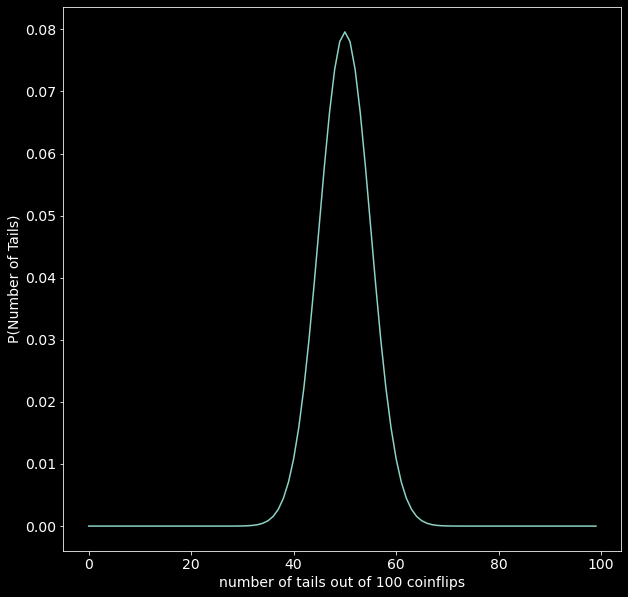

In [15]:
pl.plot(n_tails, prob_n_tails)
pl.xlabel("number of tails out of 100 coinflips")
pl.ylabel("P(Number of Tails)");

That's a Gaussian.

<cue meme>

Let's verify this with some simple experiments.  We'll use our RNG approach, setting up a function to count how many heads we get:

In [16]:
def nheads(nflips=100):
    return (np.random.rand(nflips) < 0.5).sum()

Then, let's run this experiment a couple times to get a few different outcomes...

In [17]:
nheads_from_20_experiments = [nheads() for expt_number in range(20)]
nheads_from_20_experiments

[47,
 48,
 46,
 48,
 42,
 53,
 47,
 50,
 45,
 52,
 48,
 48,
 51,
 53,
 52,
 53,
 55,
 51,
 53,
 50]

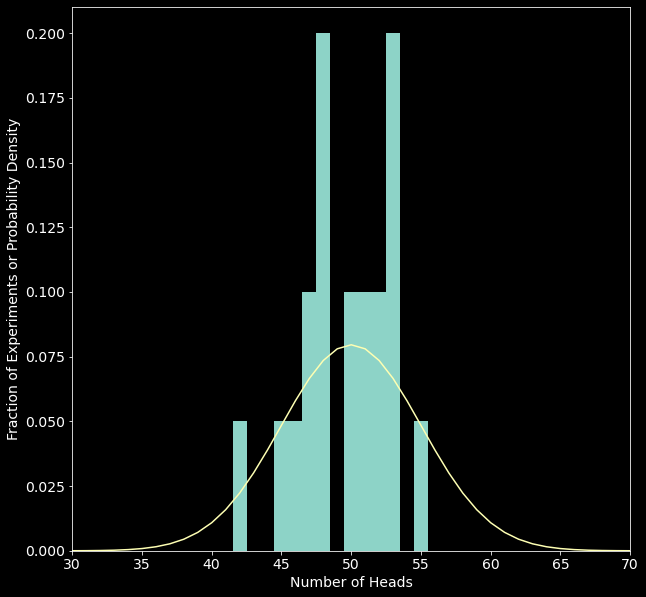

In [18]:
bins = np.arange(29.5, 71) # want discrete bins with edges between the integers
pl.hist(nheads_from_20_experiments, density=True, bins=bins)
pl.plot(n_tails, prob_n_tails)
pl.xlim(30, 70)
pl.xlabel("Number of Heads")
pl.ylabel("Fraction of Experiments or Probability Density");

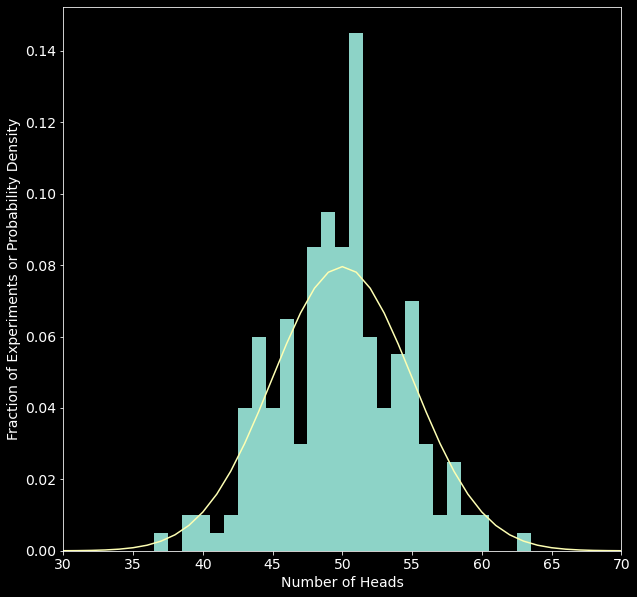

In [19]:
nheads_from_200_experiments = [nheads() for expt_number in range(200)]
pl.hist(nheads_from_200_experiments, density=True, bins=bins)
pl.plot(n_tails, prob_n_tails)
pl.xlim(30, 70)
pl.xlabel("Number of Heads")
pl.ylabel("Fraction of Experiments or Probability Density");

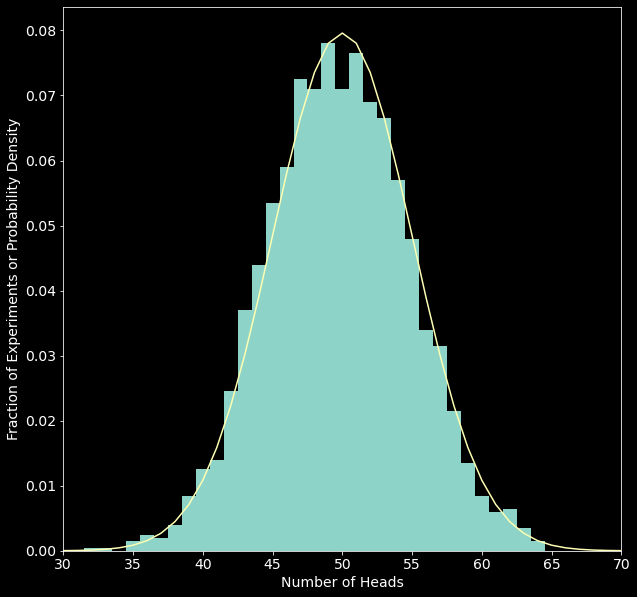

In [20]:
nheads_from_2000_experiments = [nheads() for expt_number in range(2000)]
pl.hist(nheads_from_2000_experiments, density=True, bins=bins)
pl.plot(n_tails, prob_n_tails)
pl.xlim(30, 70)
pl.xlabel("Number of Heads")
pl.ylabel("Fraction of Experiments or Probability Density");

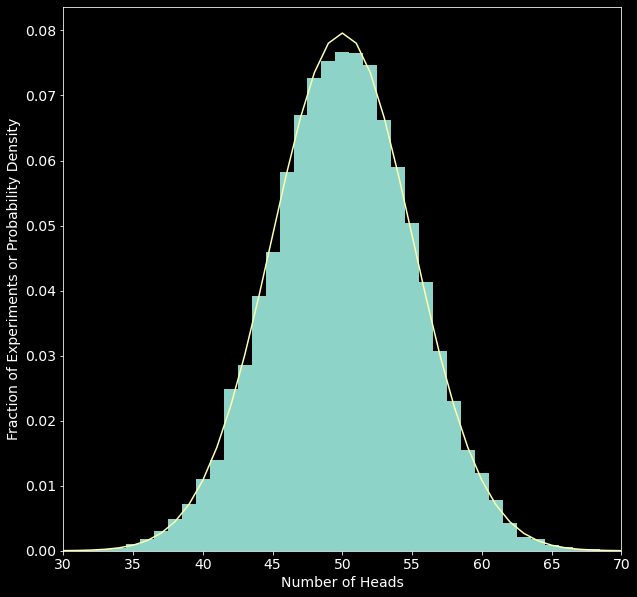

In [21]:
nheads_from_20000_experiments = [nheads() for expt_number in range(20000)]
pl.hist(nheads_from_20000_experiments, density=True, bins=bins)
pl.plot(n_tails, prob_n_tails)
pl.xlim(30, 70)
pl.xlabel("Number of Heads")
pl.ylabel("Fraction of Experiments or Probability Density");

# Properties of Gaussians

The central limit theorem loosely implies that Gaussians are the most common distribution you'll see in physics.

Some examples you've had in this class:

 * Photon arrival time probability is governed by [Poisson](https://en.wikipedia.org/wiki/Poisson_distribution) statistics, which in the large number limit, approaches a Gaussian
 * Doppler broadening in thermal gas is given by the [Maxwell-Boltzmann distribution](https://en.wikipedia.org/wiki/Maxwell%E2%80%93Boltzmann_distribution), which is a Gaussian

The general form is:
$$ f(x) = A e^{-(x-x_0)^2 / 2 \sigma^2 } $$

for any probability distribution, we require $\int p(x) = 1$, so to normalize a Gaussian, we have:

$$ p(x) = \frac{1}{\sigma \sqrt{2 \pi}} \exp\left[ \frac{-(x-x_0)^2}{2 \sigma^2}\right]$$

i.e., for $ f(x) = A e^{-(x-x_0)^2 / 2 \sigma^2 } $, $A=\frac{1}{\sigma \sqrt{2\pi}}$

What are some important properties of a Gaussian distribution?

The probability of a result landing within 1-sigma of the mean is 68%.  2-sigma is 95%.  3-sigma is 99.7%.

How do you calculate this?  We need the CDF...

The Cumulative Distribution Function is the probability P(<x), the likelihood that, for a given distribution, the result is less than some value.

It is the integral of the PDF.  

In [22]:
# the Gaussian distribution is also called the "normal" distribution
norm = scipy.stats.distributions.norm

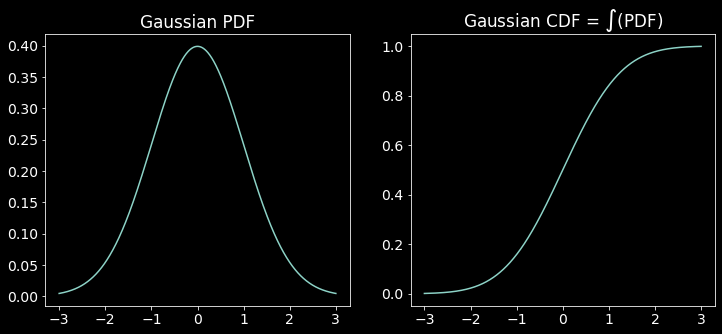

In [23]:
x = np.linspace(-3,3,1000)
pl.figure(figsize=(12,5))
_=pl.subplot(1,2,1).plot(x, norm.pdf(x)); _=pl.title("Gaussian PDF")
_=pl.subplot(1,2,2).plot(x, norm.cdf(x)); _=pl.title("Gaussian CDF = $\int$(PDF)");

The probability $$p(-\sigma < \mu < \sigma)$$ which you read as "the probability of a result being within 1-sigma of the mean", is $$P(<y) - P(<-y)$$ i.e., the evaluation of the integral $$\int_{\mu-\sigma}^{\mu+\sigma} p(x) dx$$

In [24]:
norm.cdf(1) - norm.cdf(-1)

0.6826894921370859

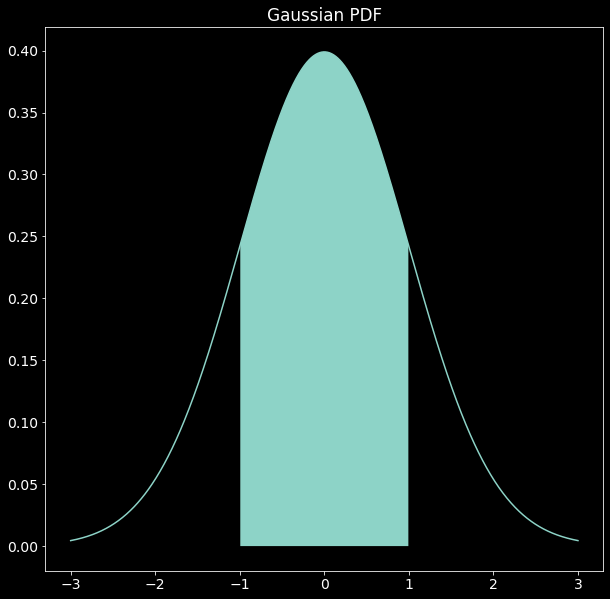

In [25]:
_=pl.plot(x, norm.pdf(x)); _=pl.title("Gaussian PDF")
_=pl.fill_between(x[(-1<x)&(x<1)], 0, norm.pdf(x[(-1<x)&(x<1)]));

In [26]:
# probability that a result lays within 1-, 2-, or 3-sigma of the mean:
norm.cdf(1) - norm.cdf(-1), norm.cdf(2) - norm.cdf(-2), norm.cdf(3) - norm.cdf(-3)

(0.6826894921370859, 0.9544997361036416, 0.9973002039367398)

Let's examine what this implies for a minute...

Say you take 3 measurements that you know come from a Gaussian distribution.  You might report your measurement by determining the _mean_ and _standard deviation_ of the data, then reporting "I measured $f(x) = \mu_{x} \pm \sigma$".

If you did this, how many of the data points will be within $1\sigma$ of the mean?

Probably only 2/3 - you should expect 1 data point to be outside that range!

Let's show an example using the `rvs` method (random variate) to get some random samples:

In [27]:
data = norm.rvs(size=3)
data

array([ 2.00876032, -1.00641813, -0.27631969])

For any given sample, this could have any number of data points inside or outside that range.... but we expect about 1/3 (32%) of the data to be outside the 1-sigma range:

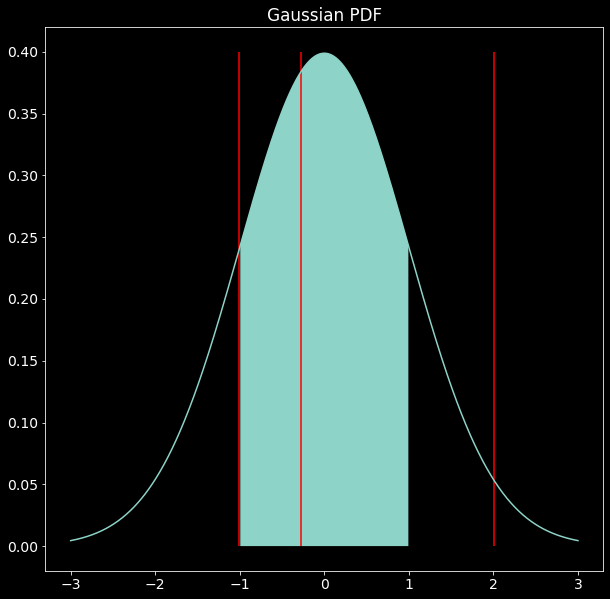

In [28]:
_=pl.plot(x, norm.pdf(x)); _=pl.title("Gaussian PDF")
_=pl.fill_between(x[(-1<x)&(x<1)], 0, norm.pdf(x[(-1<x)&(x<1)]))
_=pl.vlines(data, 0, 0.4, color='r');

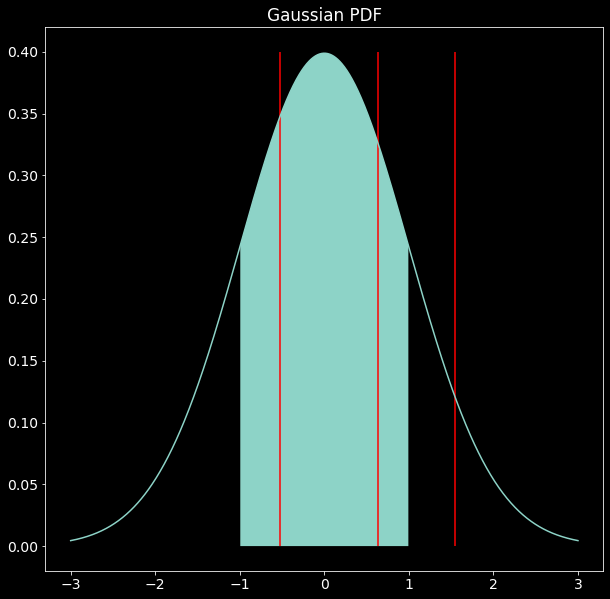

In [29]:
# re-run this cell a bunch of time to see what happens...
data = norm.rvs(size=3)
_=pl.plot(x, norm.pdf(x)); _=pl.title("Gaussian PDF")
_=pl.fill_between(x[(-1<x)&(x<1)], 0, norm.pdf(x[(-1<x)&(x<1)]))
_=pl.vlines(data, 0, 0.4, color='r');

The bigger our sample, the more we should expect the data to approach 32% outside, 68% inside, the $\pm1\sigma$ range

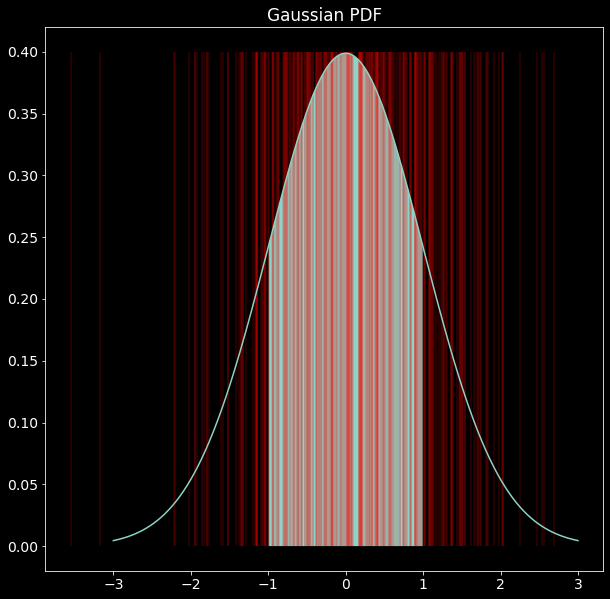

In [30]:
data = norm.rvs(size=300)
_=pl.plot(x, norm.pdf(x)); _=pl.title("Gaussian PDF")
_=pl.fill_between(x[(-1<x)&(x<1)], 0, norm.pdf(x[(-1<x)&(x<1)]))
_=pl.vlines(data, 0, 0.4, color='r', alpha=0.2);

This results in a very important *rule of thumb*: for any given set of measurements, if they are Gaussian distributed (as expected if the uncertainties are reported as $\pm<blah>$), about 1/3 should be _outside_ the $\pm1\sigma$ range.

If you look at a paper's results, and they say "we measure our errors are $\pm1$", but all of their values are in the range $\pm1$, then they have *overestimated* their error!  

Similarly, if they reported error bars such that, say, only half their data were within the errors, they *underestimated* their error.

This is a simple check you can perform on any scientific results!

# Likelihood & Maximum Likelihood Estimation

This section is similar to Section 2.1 of Bevington & Robinson, "Data Reduction for the Physical Sciences":
http://hosting.astro.cornell.edu/academics/courses/astro3310/Books/Bevington_opt.pdf

See also Stuart Littlefair's lecture on the topic:
http://slittlefair.staff.shef.ac.uk/teaching/phy217/lectures/stats/L18/index.html

# Likelihoods

The Gaussian distributions we've discussed are *models* of the data.  

Our measurements let us select appropriate models to use for further analysis.

When we measure a single value, we're implicitly measuring the *mean* of a (presumably Gaussian) distribution.

When we measure the error, we measure the *width* of that distribution.

As long as we have identified a correct model, we can use it to make predictions that extend far beyond anything we can readily measure.

How can we tell if a model is a correct - or, more often, 'good enough' - description of the world?

(this is, imo, the fundamental question Science answers!)

We define the *Likelihood* of the data, given our model, $P(D|M)$  (the $|$ is read aloud as "given" or "provided").

(we want to know the probability of the *model* given our *data*, $P(M|D)$, but that is more difficult to determine and gets into philosophy of Bayesian vs Frequentist statistics)

We'll work with a Gaussian model, 
$$ p(x) = \frac{1}{\sigma \sqrt{2 \pi}} \exp\left[ \frac{-(x-\mu)^2}{2 \sigma^2}\right]$$

The probability given any single data point is simply the above, $p(x|\mu,\sigma)$.  This is what we calculated before, the `pdf` (probability distribution function).

Generally, we're interested in the probability of a whole *data set*, many data points.

As with the heads/tails examples, the probability of many data points is their product.

$$ p(x_1, x_2, x_3, ...) = \Pi_i p(x_i) $$

To make calculation of this distribution a little more tractable, we usually work with *log probability*.

Recall that the log of a product is the sum of the logs of the individual terms, i.e., $\log(x y) = \log x + \log y$.

For probability: 

$$ p(x_1, x_2, x_3, ...) = \Pi_i p(x_i) $$

The log probability is:

$$\log p(x_1, ...) = \log \Pi_i p(x_i) = \Sigma_i \log p(x_i)$$

In the Gaussian case, i.e. for $p(x) = \frac{1}{\sigma \sqrt{2 \pi}} \exp\left[(x-x_0)/2 \sigma^2\right]$, we have log probability
$$\ln p(x) = \frac{-(x-\mu)^2}{2 \sigma_i^2} - \ln \sigma \sqrt{2 \pi} $$

So, for many data points, this is
$$\Sigma_i \ln p(x_i) = - \Sigma_i \ln \sigma \sqrt{2 \pi} + \Sigma_i \frac{-(x_i-\mu)^2}{2 \sigma^2} $$

Note that the left sum depends only on the *model*, not on the *data*.

$$\Sigma_i \ln p(x_i) = - \Sigma_i \ln \sigma_i \sqrt{2 \pi} + \Sigma_i \frac{-(x_i-\mu)^2}{2 \sigma^2} $$
The right term above defines the $\chi^2$ (Chi Squared) statistic 
$$ \chi^2 = \Sigma_i \frac{(x_i-\mu)^2}{\sigma^2}$$

The $\chi^2$ statistic is the value we try to minimize when fitting functions to data.  It can be thought of as the distance between the model and the data as weighted by the uncertainty.

# Fitting a Line

See also Ch. 6 of Bevington

There is a special case in statistics in which we can use $\chi^2$ minimization to solve for a model.

This is the case of fitting a line to the data using ["Ordinary Least Squares Regression"](https://en.wikipedia.org/wiki/Ordinary_least_squares), which is simultaneously one of the most useful and most dangerous tools available to a scientist.

In [31]:
# these data come from Hogg's table (see below)
# we assume *no measurement error* on the xvals, and sigma = measured error on yvals
xvals, yvals, sigmas = ([58, 210, 202, 198, 158, 165, 201, 157, 131, 166, 160, 186, 125, 218, 146],
                        [173, 479, 504, 510, 416, 393, 442, 317, 311, 400, 337, 423, 334, 533, 344],
                        [15, 27, 14, 30, 16, 14, 25, 52, 16, 34, 31, 42, 26, 16, 22])

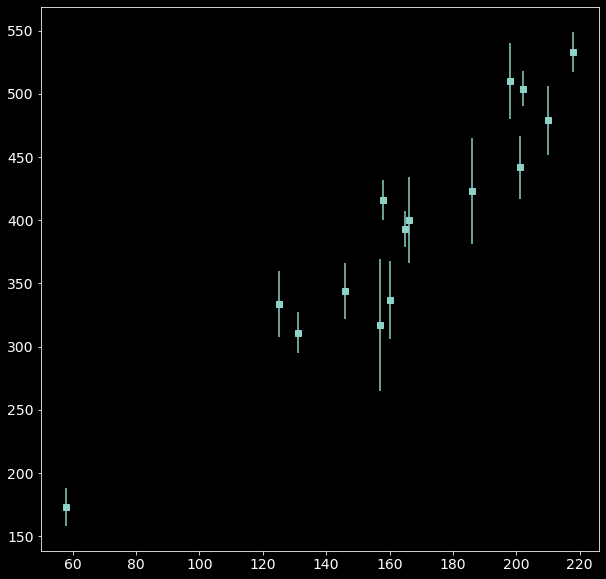

In [32]:
pl.errorbar(xvals, yvals, yerr=sigmas, linestyle='none', marker='s');

We want to fit a linear model of the form $y = m x + b$ or $f(x) = m x + b$.

We will call our data points - the *measured values* - our $z_i$, and $x$ will be our "independent" variable on the X-axis.  So we have data $z_i(x)$, each data point is measured at a *known* x-value.

$f(x)$ is the model that predicts where $z$ should be at each $x$ value, and any deviation from that is assumed to come from the Gaussian error with width $\sigma_i$.

In other words, $f(x)$ predicts the locations of the data values - or the _mean_ of the Gaussian distribution, if our data are drawn from a Gaussian distribution around some point.  $f(x)$ is a  model for the mean $\mu$.

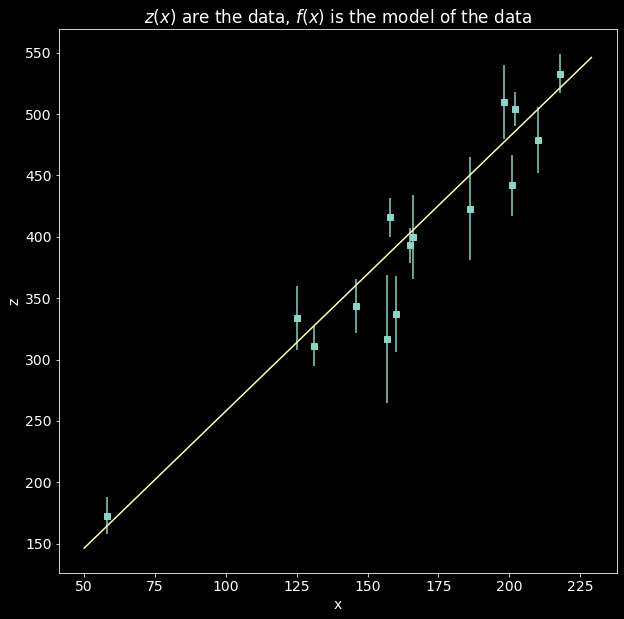

In [33]:
pl.title("$z(x)$ are the data, $f(x)$ is the model of the data")
pl.errorbar(xvals, yvals, yerr=sigmas, linestyle='none', marker='s', label='Data $z$ with error')
m_estimate, b_estimate = (2.2325362169534175, 34.8459413133985)
pl.plot(np.arange(50,230), np.arange(50,230)*m_estimate + b_estimate, label='Model f(x)');
pl.xlabel("x"); pl.ylabel("z");

Then, from our previous derivation of $\chi^2$ from the likelihood:
$$ \chi^2 = \Sigma_i \frac{(z_i-\mu)^2}{\sigma^2}$$


which becomes, if we plug in our _estimate_ of the mean $f(x)$:
$$\chi^2 = \Sigma_i \frac{\left(z_i - f(x_i)\right)^2}{\sigma_i^2} $$


or, spelled out:
$$\chi^2 = \Sigma_i \frac{\left(z_i - m x_i - b\right)^2}{\sigma_i^2} $$

equation for the likelyhood of our "data given model" 

We want to *minimize* $\chi^2$ with respect to our model parameters $m$ and $b$ ($\chi^2$ is a measurement of how far away our *model* is from our *data*), so we take  derivatives and look for the extrema.  

We will take two derivatives, starting with $d/db$:

$$\frac{d \chi^2}{d b} = \frac{d}{db}\left( \Sigma_i \frac{\left(z_i - m x_i - b\right)^2}{\sigma_i^2}\right) $$

$$= \Sigma_i \frac{-2 \left(z_i - m x_i - b\right)}{\sigma_i^2}$$

This reaches a maximum when $$\Sigma_i \frac{\left(z_i - m x_i - b\right)}{\sigma_i^2} = 0$$


We have:
$$\Sigma_i \frac{\left(z_i - m x_i - b\right)}{\sigma_i^2} = 0$$

so, solving for $b$, we get: 
$$b \Sigma_i \frac{1}{\sigma_i^2} = \Sigma_i \frac{z_i}{\sigma_i^2} - \Sigma_i \frac{m x_i}{\sigma_i^2}$$

Which rearranges to the general case:

$$b  = \frac{\Sigma_i \frac{z_i}{\sigma_i^2} - \Sigma_i \frac{m x_i}{\sigma_i^2}}{\Sigma_i \frac{1}{\sigma_i^2}}$$

In the case $\sigma_i$ is constant, the general solution reduces to (I'll repeat this on the next slide): $$b = \frac{1}{N} \Sigma_i (z_i - m x_i) = \frac{1}{N} \Sigma_i z_i - \frac{m}{N} \Sigma x_i $$

(repeated from above)
The solution for the intercept of a line fitted to data in the case that all uncertainties are the same:
$$b = \frac{1}{N} \Sigma_i (z_i - m x_i) = \frac{1}{N} \Sigma_i z_i - \frac{m}{N} \Sigma x_i $$

A sum divided by $N$ is a mean, so $\frac{\Sigma_i z_i}{N} = \bar{z}$, the mean of the *data*, and $\frac{\Sigma_i x_i}{N} = \bar{x}$, the mean of the X-axis.

In the more general case, $1/\sigma_i^2$ is the inverse-variance, so the means are inverse-variance-weighted means.

Therefore, $b = \bar{z} - m \bar{x}$

Recall our definition of $\chi^2$:
$$\chi^2 = \Sigma_i \frac{\left(z_i - m x_i - b\right)^2}{\sigma_i^2} $$
Continuing along, we substitute $b = \bar{z} - m \bar{x}$ before taking the next derivative $d \chi^2/dm$:

$$\chi^2 = \Sigma_i \frac{\left(z_i - m x_i - (\bar{z}-m\bar{x})\right)^2}{\sigma_i^2} 
         = \Sigma_i \frac{\left[(z_i - \bar{z}) - m (x_i - \bar{x})\right]^2}{\sigma_i^2} $$

The derivative $d/dm$ is then:

$$\frac{d \chi^2}{d m} = \Sigma_i \frac{-2 (x_i-\bar{x}) \left[(z_i-\bar{z}) - m (x_i - \bar{x})\right]}{\sigma_i^2}$$

To find its maximum, we set the derivative $d\chi^2/dm=0$ as before:
$$\Sigma_i \frac{(x_i-\bar{x}) \left[(z_i-\bar{z}) - m (x_i - \bar{x}) \right]}{\sigma_i^2} = 0$$

$$\Sigma_i \frac{(x_i-\bar{x}) \left[z_i-\bar{z}\right]}{\sigma_i^2} =  m \Sigma_i \frac{(x_i-\bar{x}) \left[x_i - \bar{x}\right]}{\sigma_i^2}$$

$$m = \frac{\Sigma_i (x_i-\bar{x}) \left(z_i-\bar{z}\right) \sigma_i^{-2}}{ \Sigma_i \left[x_i - \bar{x}\right]^2 \sigma_i^{-2}}$$

The Ordinary Least Squares equations are quite simple, requiring only linear algebra to solve.

$$m = \frac{\Sigma_i (x_i-\bar{x}) \left(z_i-\bar{z}\right) \sigma_i^{-2}}{ \Sigma_i \left[x_i - \bar{x}\right]^2 \sigma_i^{-2}}$$


$$b  = \frac{\Sigma_i z_i \sigma_i^{-2} - \Sigma_i m x_i \sigma_i^{-2}}{\Sigma_i \sigma_i^{-2}}$$

Now we'll dig into an example provided by David Hogg in https://arxiv.org/pdf/1008.4686.pdf


In [34]:
# these data come from his table
# we assume *no measurement error* on the xvals, and sigma = measured error on yvals
xvals, yvals, sigmas = ([58, 210, 202, 198, 158, 165, 201, 157, 131, 166, 160, 186, 125, 218, 146],
                        [173, 479, 504, 510, 416, 393, 442, 317, 311, 400, 337, 423, 334, 533, 344],
                        [15, 27, 14, 30, 16, 14, 25, 52, 16, 34, 31, 42, 26, 16, 22])

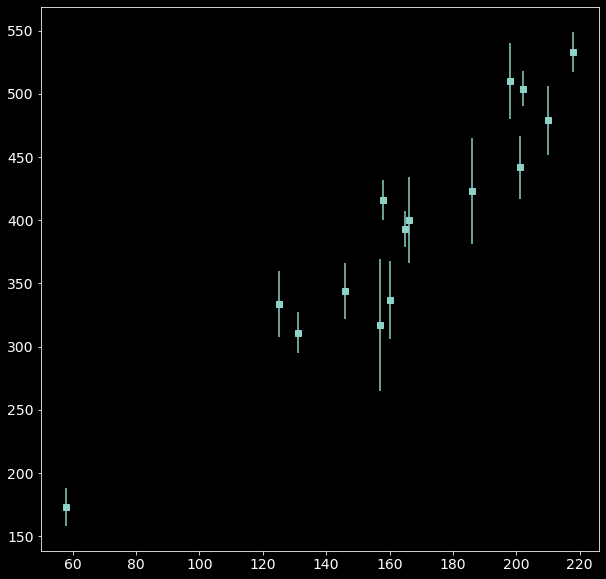

In [35]:
pl.errorbar(xvals, yvals, yerr=sigmas, linestyle='none', marker='s');

In [36]:
# these are the implementations of the Ordinary Least Squares equations
variance = np.array(sigmas)**2
m_estimate = (np.sum( (xvals - np.average(xvals, weights=1/variance)) 
                    * (yvals - np.average(yvals, weights=1/variance))
                    * 1/variance
                   )
              / np.sum((xvals-np.average(xvals, weights=1/variance))**2 * 1/variance)
             )
b_estimate = np.average(yvals, weights=1/variance) - m_estimate * np.average(xvals, weights=1/variance)
m_estimate, b_estimate

(2.2325362169534175, 34.8459413133985)

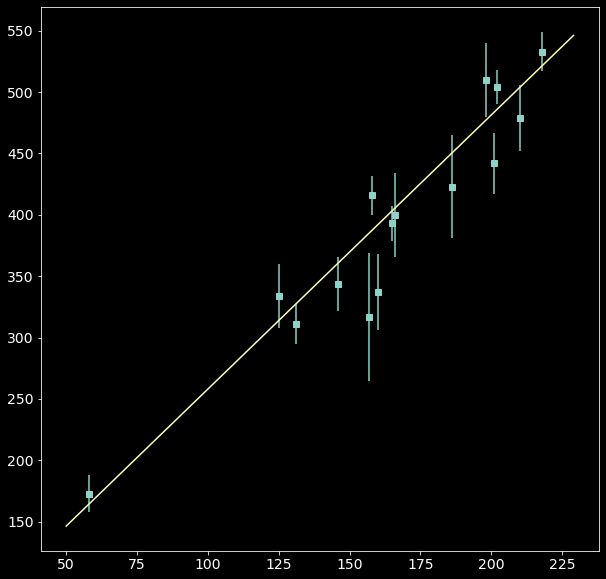

In [37]:
pl.errorbar(xvals, yvals, yerr=sigmas, linestyle='none', marker='s')
pl.plot(np.arange(50,230), np.arange(50,230)*m_estimate + b_estimate);

In [38]:
residual = yvals - (np.array(xvals) * m_estimate + b_estimate)

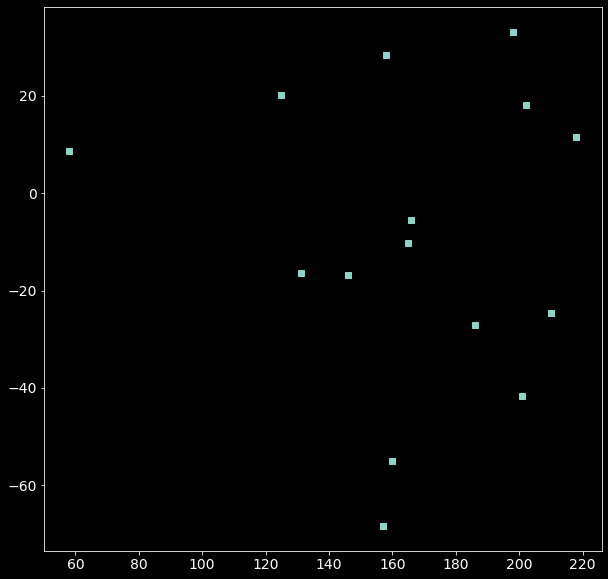

In [39]:
pl.plot(xvals, residual, 's');

Ordinary Least Squares is a powerful tool, but it applies in relatively few circumstances.

More generally, we use this overall approach with numerical fitters such as the ``LevMarLSQFitter`` from astropy to obtain numerical (approximate) solutions to the maximum likelihood equations.

Astropy's ``LinearLSQFitter`` implements a nearly-analytic solution like the one we derived.

# Exercise:

Using the tools we covered in class, fit a line to these data 

In [40]:
print(f"x={xvals[:5]}\ny={yvals[:5]}\nsigma={sigmas[:5]}")

x=[58, 210, 202, 198, 158]
y=[173, 479, 504, 510, 416]
sigma=[15, 27, 14, 30, 16]


In [41]:
xvals1 = xvals[:5]
yvals1 = yvals[:5]
sigmas1 = sigmas[:5]

$$m = \frac{\Sigma_i (x_i-\bar{x}) \left(z_i-\bar{z}\right) \sigma_i^{-2}}{ \Sigma_i \left[x_i - \bar{x}\right]^2 \sigma_i^{-2}}$$


$$b  = \frac{\Sigma_i z_i \sigma_i^{-2} - \Sigma_i m x_i \sigma_i^{-2}}{\Sigma_i \sigma_i^{-2}}$$

(end)

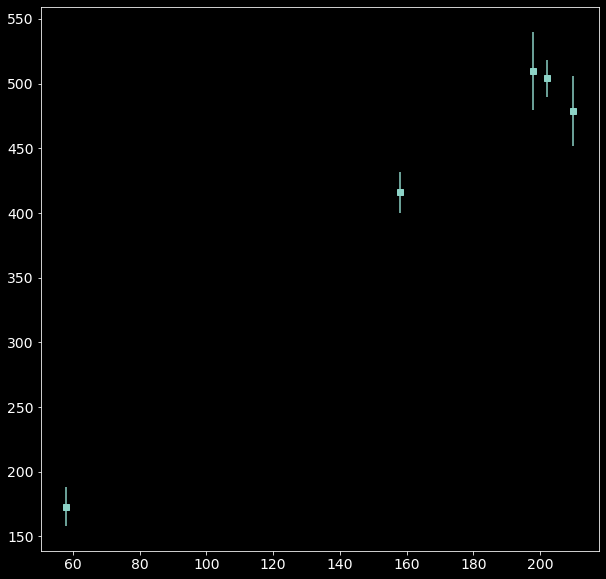

In [42]:
pl.errorbar(xvals1, yvals1, yerr=sigmas1, linestyle='none', marker='s');

In [43]:
variance1 = np.array(sigmas1)**2
m_estimate1 = (np.sum( (xvals1 - np.average(xvals1, weights=1/variance1)) 
                    * (yvals1 - np.average(yvals1, weights=1/variance1))
                    * 1/variance1
                   )
              / np.sum((xvals1-np.average(xvals1, weights=1/variance1))**2 * 1/variance1)
             )
b_estimate1 = np.average(yvals1, weights=1/variance1) - m_estimate1 * np.average(xvals1, weights=1/variance1)
m_estimate1, b_estimate1

(2.2586494698714477, 46.278447127397726)

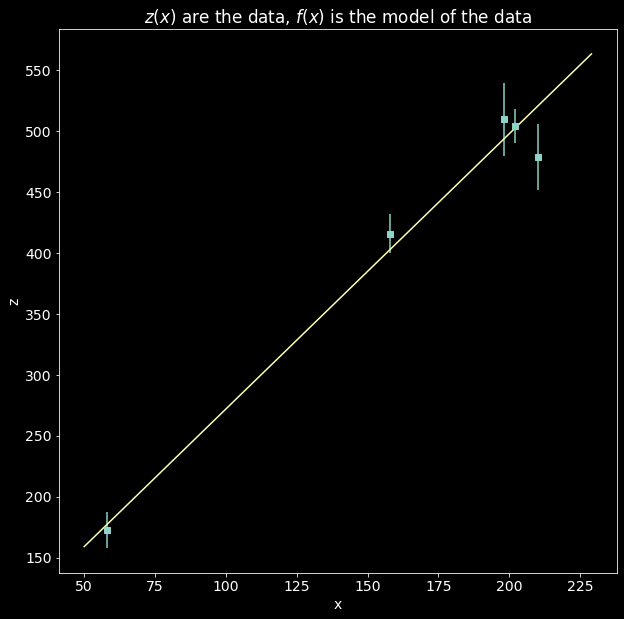

In [44]:
pl.title("$z(x)$ are the data, $f(x)$ is the model of the data")
pl.errorbar(xvals1, yvals1, yerr=sigmas1, linestyle='none', marker='s', label='Data $z$ with error')
m_estimate, b_estimate = (2.2586494698714477, 46.278447127397726)
pl.plot(np.arange(50,230), np.arange(50,230)*m_estimate1 + b_estimate1, label='Model f(x)');
pl.xlabel("x"); pl.ylabel("z");

In [45]:
residual1 = yvals1 - (np.array(xvals1) * m_estimate1 + b_estimate1)

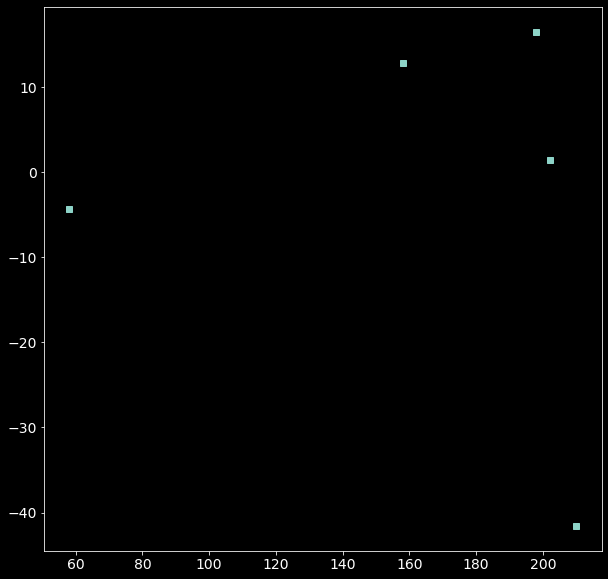

In [46]:
pl.plot(xvals1, residual1, 's');